# Initialization

In [1]:
import re
import os.path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
artist_df = pd.read_csv('artists.csv').set_index('id')
song_df = pd.read_csv('songs.csv').set_index('id')

# Data preprocessing

## `artists.csv`

In [3]:
artist_df.head()

,name,members
id,,
32,A-RISE,綺羅ツバサ （CV: 櫻川めぐ）|統堂英玲奈 （CV: 松永真穂）|優木あんじゅ （CV: ...
35,AZALEA,松浦果南 （CV: 諏訪ななか）|黒澤ダイヤ （CV: 小宮有紗）|国木田花丸 （CV: 高...
33,Aqours,高海千歌 （CV: 伊波杏樹）|桜内梨子 （CV: 逢田梨香子）|松浦果南 （CV: 諏訪な...
101,Aqours・虹ヶ咲学園スクールアイドル同好会・Liella!,高海千歌 （CV: 伊波杏樹）|桜内梨子 （CV: 逢田梨香子）|松浦果南 （CV: 諏訪な...
62,A・ZU・NA,上原歩夢 （CV: 大西亜玖璃）|桜坂しずく （CV: 前田佳織里）|優木せつ菜 （CV: ...


### View `NaN` ratio

In [4]:
artist_df.agg(lambda col: col.isna().mean())

name       0.0
members    0.0
dtype: float64

### Remove seiyuu information from `members` column

In [5]:
members = artist_df.members.str.split('|')
members = members.apply(lambda x: [re.search('(.*) （(?:.*)）', str(i)).group(1) for i in x])
artist_df.members = members

### Determine main group (Aqours, Nijigasaki, etc.) for each `artist`

In [6]:
aqours_members = artist_df.query('name == "Aqours"').members.iloc[0]
muse_members = artist_df.query('name == "μ\'s"').members.iloc[0]
niji_members = artist_df.query('name == "虹ヶ咲学園スクールアイドル同好会（12人）"').members.iloc[0]
liella_members = artist_df.query('name == "Liella!"').members.iloc[0]
arise_members = artist_df.query('name == "A-RISE"').members.iloc[0]
sunnypa_members = artist_df.query('name == "Sunny Passion"').members.iloc[0]
saintsnow_members = artist_df.query('name == "Saint Snow"').members.iloc[0]

In [7]:
group_map = {
    'Aqours': set(aqours_members),
    'μ\'s': set(muse_members),
    'Nijigasaki': set(niji_members),
    'Liella': set(liella_members),
    'ARISE': set(arise_members),
    'Sunny Passion': set(sunnypa_members),
    'Saint Snow': set(saintsnow_members),
}

In [8]:
artist_df.members

id
32                                [綺羅ツバサ, 統堂英玲奈, 優木あんじゅ]
35                                  [松浦果南, 黒澤ダイヤ, 国木田花丸]
33     [高海千歌, 桜内梨子, 松浦果南, 黒澤ダイヤ, 渡辺 曜, 津島善子, 国木田花丸, 小...
101    [高海千歌, 桜内梨子, 松浦果南, 黒澤ダイヤ, 渡辺 曜, 津島善子, 国木田花丸, 小...
62                                  [上原歩夢, 桜坂しずく, 優木せつ菜]
                             ...                        
55                [高海千歌, 桜内梨子, 渡辺 曜, 津島善子, 国木田花丸, 黒澤ルビィ]
90                                   [高海千歌, 黒澤ダイヤ, 津島善子]
42                                               [黒澤ダイヤ]
49                                        [黒澤ダイヤ, 黒澤ルビィ]
47                                               [黒澤ルビィ]
Name: members, Length: 108, dtype: object

In [9]:
def determine_main_group(group_set):
    groups = []
    # Determine the main group of a group
    for main_group, members in group_map.items():
        if set(group_set).issubset(members) or members.issubset(group_set):
            groups.append(main_group)
    return groups

artist_df['main_group'] = artist_df.members.apply(determine_main_group)

In [10]:
artist_df

,name,members,main_group
id,,,
32,A-RISE,"[綺羅ツバサ, 統堂英玲奈, 優木あんじゅ]",[ARISE]
35,AZALEA,"[松浦果南, 黒澤ダイヤ, 国木田花丸]",[Aqours]
33,Aqours,"[高海千歌, 桜内梨子, 松浦果南, 黒澤ダイヤ, 渡辺 曜, 津島善子, 国木田花丸, 小...",[Aqours]
101,Aqours・虹ヶ咲学園スクールアイドル同好会・Liella!,"[高海千歌, 桜内梨子, 松浦果南, 黒澤ダイヤ, 渡辺 曜, 津島善子, 国木田花丸, 小...","[Aqours, Nijigasaki, Liella]"
62,A・ZU・NA,"[上原歩夢, 桜坂しずく, 優木せつ菜]",[Nijigasaki]
...,...,...,...
55,高海千歌、桜内梨子、渡辺 曜、津島善子、国木田花丸、黒澤ルビィ,"[高海千歌, 桜内梨子, 渡辺 曜, 津島善子, 国木田花丸, 黒澤ルビィ]",[Aqours]
90,高海千歌、黒澤ダイヤ、津島善子,"[高海千歌, 黒澤ダイヤ, 津島善子]",[Aqours]
42,黒澤ダイヤ,[黒澤ダイヤ],[Aqours]


## `songs.csv`

In [11]:
song_df.head()

,name,date,artists,lyricists,composers,arrangers,discs,events
id,,,,,,,,
1,僕らのLIVE 君とのLIFE,2010年8月25日,μ's,畑 亜貴,山田高弘,高田 暁,"{1, 166, 23}","[{'event': '38', 'concert': '63', 'performance..."
2,友情ノーチェンジ,2010年8月25日,μ's,畑 亜貴,Tron-LM,Tron-LM,"{1, 166, 23}","[{'event': '107', 'concert': '145', 'performan..."
3,Snow halation,2010年12月22日,μ's,畑 亜貴,山田高弘,中西亮輔,"{2, 166, 23}","[{'event': '38', 'concert': '63', 'performance..."
4,baby maybe 恋のボタン,2010年12月22日,μ's,畑 亜貴,山口朗彦,山口朗彦,"{2, 166, 23}","[{'event': '107', 'concert': '145', 'performan..."
5,Love marginal,2011年5月25日,Printemps,畑 亜貴,藤末 樹,松坂康司、藤末 樹,"{3, 166, 23}","[{'event': '98', 'concert': '134', 'performanc..."


### View `NaN` ratio

In [12]:
song_df.agg(lambda col: col.isna().mean())

name         0.000000
date         0.002463
artists      0.002463
lyricists    0.002463
composers    0.002463
arrangers    0.004926
discs        0.000000
events       0.000000
dtype: float64

In [13]:
song_df.dropna(thresh=2, inplace=True)
song_df.agg(lambda col: col.isna().mean())

name         0.000000
date         0.002463
artists      0.002463
lyricists    0.002463
composers    0.002463
arrangers    0.004926
discs        0.000000
events       0.000000
dtype: float64

### Join on artist column to determine main group of each song

In [14]:
song_df = song_df.merge(
    artist_df[['name', 'main_group']],
    how='inner', 
    left_on='artists', 
    right_on='name'
)

In [15]:
del song_df['name_y']
song_df.rename({'name_x': 'name'}, inplace=True, axis=1)

In [16]:
song_df.main_group.value_counts()

[Aqours]                        135
[μ's]                           117
[Nijigasaki]                     85
[Liella]                         42
[]                               12
[Saint Snow]                      7
[ARISE]                           2
[Aqours, Saint Snow]              2
[Sunny Passion]                   2
[Aqours, Nijigasaki, Liella]      1
Name: main_group, dtype: int64

There are a few missing `main_group` values. Let's check.

In [17]:
empty_group_rows = ~song_df.main_group.apply(lambda x: bool(x))
song_df[empty_group_rows]

,name,date,artists,lyricists,composers,arrangers,discs,events,main_group
112,革命ですね？神様！,2013年4月24日,早乙女リリエル、竜崎クロウエル、白鳥ラナエル、綾小路シェリエル、東條ネルエル,畑 亜貴,矢鴇つかさ（Arte Refact）,矢鴇つかさ（Arte Refact）,{169},[],[]
113,羽は知ってしまったの？,2013年4月24日,早乙女リリエル,畑 亜貴,原田 篤（Arte Refact）,fandelmale（Arte Refact）,{169},[],[]
114,閃光Resolution,2013年4月24日,竜崎クロウエル,畑 亜貴,五条下位（Arte Refact）,五条下位（Arte Refact）,{169},[],[]
115,斯くも憂美な日となりて,2013年4月24日,白鳥ラナエル,畑 亜貴,原田 篤（Arte Refact）,fandelmale（Arte Refact）,{169},[],[]
116,I'll smile for yours,2013年4月24日,綾小路シェリエル,畑 亜貴,矢鴇つかさ（Arte Refact）,矢鴇つかさ（Arte Refact）,{169},[],[]
117,コドクの回廊,2013年4月24日,東條ネルエル,畑 亜貴,酒井拓也（Arte Refact）,酒井拓也（Arte Refact）,{169},[],[]
118,秘密と花園,2013年4月24日,恋塚フルーネティ,畑 亜貴,原田 篤（Arte Refact）,fandelmale（Arte Refact）,{169},[],[]
119,ここで待ってるよ,2013年4月24日,神楽坂ミナモ,畑 亜貴,酒井拓也（Arte Refact）,酒井拓也（Arte Refact）,{169},[],[]
120,夢☆ONCE AGAIN,2013年4月24日,アサギ,畑 亜貴,西添 健（Arte Refact）,fandelmale（Arte Refact）,{169},[],[]
121,"NEURON,NEURON!!",2013年4月24日,ミザリィ,畑 亜貴,矢鴇つかさ（Arte Refact）,矢鴇つかさ（Arte Refact）,{169},[],[]


For the time being, `main_group` for `344` will be `Aqours`, and the rest will be `μ's`

In [18]:
song_df.loc[344, 'main_group'] = ['Aqours']
song_df.loc[empty_group_rows, 'main_group'] = [['μ\'s']]

In [19]:
song_df.main_group.value_counts()

[Aqours]                        135
[μ's]                           129
[Nijigasaki]                     85
[Liella]                         42
[Saint Snow]                      7
[ARISE]                           2
[Aqours, Saint Snow]              2
[Sunny Passion]                   2
[Aqours, Nijigasaki, Liella]      1
Name: main_group, dtype: int64

### Type conversion

#### `date` column should be of type `datetime`

In [20]:
song_df.date = pd.to_datetime(song_df.date, format='%Y年%m月%d日')

#### `discs` column should be of type `list`

In [21]:
song_df.discs.head()

0    {1, 166, 23}
1    {1, 166, 23}
2    {2, 166, 23}
3    {2, 166, 23}
4    {166, 6, 23}
Name: discs, dtype: object

In [22]:
song_df.discs = song_df.discs.str.findall('(\d+)')

#### `arrangers` column should be of type `list`

In [23]:
song_df.arrangers = song_df.arrangers.str.split('、')

In [24]:
arrangers = song_df.explode('arrangers').arrangers
arrangers.unique(), arrangers.nunique()

(array(['高田 暁', 'Tron-LM', '中西亮輔', '山口朗彦', '渡辺和紀', 'A-bee', '清水哲平', '河田貴央',
        '黒須克彦', '森慎太郎', '佐々倉有吾', '佐々木裕', '倉内達矢', '矢吹香那', '増田武史', '佐伯高志',
        '本田光史郎', '前口 渉', 'Kon-K', 'EFFY', '西岡和哉', '酒井陽一',
        'TO-MAS SOUNDSIGHT FLUORESCENT FOREST', '増谷 賢', '松坂康司', '藤末 樹',
        '中土智博', '山田竜平', '木村有希', '福富雅之', '青木多果', '山元祐介', '三浦誠司', '八重樫ゆう一',
        '渡辺未来', '藤澤慶昌', '松井 望', '安藤高弘', '鈴木裕明', '森谷敏紀', '若林 充', '藤田宜久',
        '近藤圭一', '河原嶺旭', 'lotta', '板垣祐介', '矢鴇つかさ（Arte Refact）',
        'fandelmale（Arte Refact）', '五条下位（Arte Refact）',
        '酒井拓也（Arte Refact）', '岡本健介', '宮崎 誠', '伊藤 賢', '田中俊亮', '小高光太郎',
        '藤井亮太', '松田彬人', '早川博隆', 'Shinji Tanaka', 'TAKAROT', 'ラムシーニ',
        'EFFY(FirstCall)', '脇 眞富（Arte Refact）', '加藤達也', '光増ハジメ(FirstCall)',
        'APAZZI', 'Carlos K.', 'Keisuke Koyama', 'MEG', '小松一也',
        'Soma Genda', '渡辺拓也', '谷 ナオキ(HANO)', '本間昭光', 'TAKUYA', 'ミト',
        '金崎真士', '竹市佳伸', 'TECHNOBOYS PULCRAFT GREEN-FUND',
        'Kohei by SIMONSAYZ', '黒川陽介', 'TO-me', 'R・

`EFFY` and `EFFY(FirstCall)` are likely to be one person (from Googling). Let's assume that this is also the case for other arrangers as well (the text in the parentheses are not important).

Now let's try removing the parts in the parentheses from the `arrangers` column and observe the result.

In [25]:
new_arrangers = arrangers.apply(lambda x: re.sub('\(.*\)|（.*）', '', str(x)))
new_arrangers.unique(), new_arrangers.nunique()

(array(['高田 暁', 'Tron-LM', '中西亮輔', '山口朗彦', '渡辺和紀', 'A-bee', '清水哲平', '河田貴央',
        '黒須克彦', '森慎太郎', '佐々倉有吾', '佐々木裕', '倉内達矢', '矢吹香那', '増田武史', '佐伯高志',
        '本田光史郎', '前口 渉', 'Kon-K', 'EFFY', '西岡和哉', '酒井陽一',
        'TO-MAS SOUNDSIGHT FLUORESCENT FOREST', '増谷 賢', '松坂康司', '藤末 樹',
        '中土智博', '山田竜平', '木村有希', '福富雅之', '青木多果', '山元祐介', '三浦誠司', '八重樫ゆう一',
        '渡辺未来', '藤澤慶昌', '松井 望', '安藤高弘', '鈴木裕明', '森谷敏紀', '若林 充', '藤田宜久',
        '近藤圭一', '河原嶺旭', 'lotta', '板垣祐介', '矢鴇つかさ', 'fandelmale', '五条下位',
        '酒井拓也', '岡本健介', '宮崎 誠', '伊藤 賢', '田中俊亮', '小高光太郎', '藤井亮太', '松田彬人',
        '早川博隆', 'Shinji Tanaka', 'TAKAROT', 'ラムシーニ', '脇 眞富', '加藤達也',
        '光増ハジメ', 'APAZZI', 'Carlos K.', 'Keisuke Koyama', 'MEG', '小松一也',
        'Soma Genda', '渡辺拓也', '谷 ナオキ', '本間昭光', 'TAKUYA', 'ミト', '金崎真士',
        '竹市佳伸', 'TECHNOBOYS PULCRAFT GREEN-FUND', 'Kohei by SIMONSAYZ',
        '黒川陽介', 'TO-me', 'R・O・N', 'YASUSHI WATANABE', 'ulala', '本多友紀',
        '馬渕直純', '石倉誉之', 'pw.a', '原田 篤', '江上浩太郎', 'Shoma Yamamoto', '増田基生',

The assumption is correct (numbers of unique `arrangers` only decreased by one (two `EFFY`s are the same person).

Before moving on, we shall fill `NaN` values in `arrangers` column with an empty list (since the type must be `list`).

In [26]:
isnull = song_df.arrangers.isna()
song_df.loc[isnull, 'arrangers'] = [[[]] * isnull.sum()]

In [27]:
song_df.arrangers.isna().mean()

0.0

Now remove the parentheses from the `arrangers` column.

In [28]:
song_df.arrangers = song_df.arrangers.apply(lambda row: [re.sub('\(.*\)|（.*）', '', str(x)) for x in row])

#### `composers` column should be of type list

In [29]:
song_df.composers = song_df.composers.str.split('、')

In [30]:
song_df.composers = song_df.composers.apply(lambda row: [re.sub('\(.*\)|（.*）', '', str(x)) for x in row])

In [31]:
song_df.composers.explode().unique()

array(['山田高弘', 'Tron-LM', '山口朗彦', '奥松 誠', '俊龍', '増田達行', '河田貴央', '黒須克彦',
       '森慎太郎', '高田 暁', '佐々倉有吾', '佐々木裕', '倉内達矢', '矢吹香那', '江並哲志', '渡辺和紀',
       '佐伯高志', '高阪昌至', '本田光史郎', '前口 渉', 'TSUKASA', 'ZAQ', '西岡和哉', '酒井陽一',
       'ミト', '伊藤真澄', '増谷 賢', '藤末 樹', '中土智博', '増田武史', '山田竜平', '吉田勝弥',
       '木村有希', '川崎里実', '星 和生', '青木多果', '杉森舞', '三浦誠司', 'rino', '八重樫ゆう一',
       '渡辺未来', '藤澤慶昌', '山崎真吾', '須田真吾', '鈴木裕明', '山元祐介', '若林 充', '近藤圭一',
       '河原嶺旭', 'yozuca*', '板垣祐介', '矢鴇つかさ', '原田 篤', '五条下位', '酒井拓也', '西添 健',
       '岡本健介', 'Herman Hupfeld', '光増ハジメ', '宮崎 誠', '伊藤 賢', '桑原 聖', 'EFFY',
       '田中俊亮', '小高光太郎', '藤井亮太', '松田彬人', '渡辺拓也', '早川博隆', 'KOUDAI IWATSUBO',
       'TAKAROT', 'UiNA', '原 知也', 'Carlos K.', '加藤達也', 'イワツボコーダイ',
       'Akira Sunset', 'Kanata Okajima', 'Keisuke Koyama', 'MEG',
       'Soma Genda', 'Kon-K', 'TAKUYA', 'ミト ', '金崎真士', '竹市佳伸',
       'Kohei by SIMONSAYZ', '黒川陽介', 'YU-G', 'TO-me', 'R・O・N', '本多友紀',
       'YASUSHI WATANABE', 'ulala', '杉山勝彦', 'ラムシーニ', '内田陽吾',
       'Ankle Brea

#### `lyricists` column should be of type list

In [32]:
song_df.lyricists = song_df.lyricists.str.split('、')

In [33]:
song_df.lyricists = song_df.lyricists.apply(lambda row: [re.sub('\(.*\)|（.*）', '', str(x)) for x in row])

In [34]:
song_df.lyricists.explode().unique()

array(['畑 亜貴', '京極尚彦', 'Herman Hupfeld', 'Kanata Okajima', 'Ayaka Miyake',
       'Ryota Saito', 'Akira Sunset', 'nana hatori', 'shun ÷1', 'JOE',
       '鈴木エレカ', '月見草', '鈴木まなか', 'BEATNINE', 'T4K', 'Diz', '近谷直之',
       'Carlos K.', 'NOVECHIKA', '菊池博人', 'クボナオキ', 'Dummy Dog', '栗原 暁',
       'miyakei', 'hot tears', 'PASSiON KiNG', 'Rico', '米澤森人', '藤原彩豊',
       '村木海季男', '要田 健', 'DAICHI', '柿沼雅美', '中村 歩', '宮嶋淳子', 'KEN THE 390',
       'Lauren Kaori'], dtype=object)

### Parse json data from `events`

In [35]:
song_df.events = song_df.events.apply(lambda x: json.loads(x.replace('\'', '"')))

In [36]:
song_df.sample(10)

,name,date,artists,lyricists,composers,arrangers,discs,events,main_group
248,Never giving up!,2020-08-01,高海千歌,[畑 亜貴],[EFFY],[EFFY],[174],[],[Aqours]
118,秘密と花園,2013-04-24,恋塚フルーネティ,[畑 亜貴],[原田 篤],[fandelmale],[169],[],[μ's]
382,Queendom,2021-10-06,鐘 嵐珠,[BEATNINE],[BEATNINE],[BEATNINE],[225],"[{'event': '112', 'concert': '173', 'performan...",[Nijigasaki]
306,眠れる森に行きたいな,2018-11-21,近江彼方,"[Diz, Ryota Saito]","[Diz, Ryota Saito]","[Diz, Ryota Saito]",[157],"[{'event': '70', 'concert': '96', 'performance...",[Nijigasaki]
87,シアワセ行きのSMILING!,2014-06-20,高坂穂乃果,[畑 亜貴],[渡辺未来],[渡辺未来],"[184, 82, 166]","[{'event': '91', 'concert': '119', 'performanc...",[μ's]
384,I’m Still...,2021-10-06,ミア・テイラー,[nana hatori],[ソラノアルト],[ソラノアルト],[225],"[{'event': '112', 'concert': '173', 'performan...",[Nijigasaki]
228,想いよひとつになれ,2016-11-09,高海千歌、松浦果南、黒澤ダイヤ、渡辺 曜、津島善子、国木田花丸、小原鞠莉、黒澤ルビィ,[畑 亜貴],[佐伯高志],[佐伯高志],"[178, 108]","[{'event': '33', 'concert': '58', 'performance...",[Aqours]
401,クレッシェンドゆ・ら,2022-02-25,唐 可可、葉月 恋,[宮嶋淳子],[三好啓太],[三好啓太],[243],[],[Liella]
231,SELF CONTROL!!,2016-11-30,Saint Snow,[畑 亜貴],[河田貴央],[河田貴央],[110],"[{'event': '43', 'concert': '69', 'performance...",[Saint Snow]
170,"冒険Type A, B, C!!",2019-07-26,Aqours,[畑 亜貴],[倉内達矢],[倉内達矢],"[224, 167]","[{'event': '116', 'concert': '158', 'performan...",[Aqours]


# Data analysis

## New song release by each group in every year?

In [37]:
song_grp_expl_df = song_df.explode('main_group')

In [38]:
song_grp_expl_df['year'] = song_grp_expl_df.date.dt.year

In [39]:
group_year_count = song_grp_expl_df.groupby(['year', 'main_group']).size()
group_year_count

year  main_group   
2010  μ's               4
2011  μ's              10
2012  μ's              21
2013  ARISE             1
      μ's              35
2014  ARISE             1
      μ's              32
2015  Aqours            3
      μ's              20
2016  Aqours           25
      Saint Snow        1
      μ's               4
2017  Aqours           28
      Saint Snow        3
2018  Aqours           20
      Nijigasaki       10
2019  Aqours           23
      Nijigasaki       10
      Saint Snow        2
2020  Aqours           11
      Nijigasaki       33
      Saint Snow        3
      μ's               3
2021  Aqours           26
      Liella           36
      Nijigasaki       33
2022  Aqours            2
      Liella            7
      Sunny Passion     2
dtype: int64

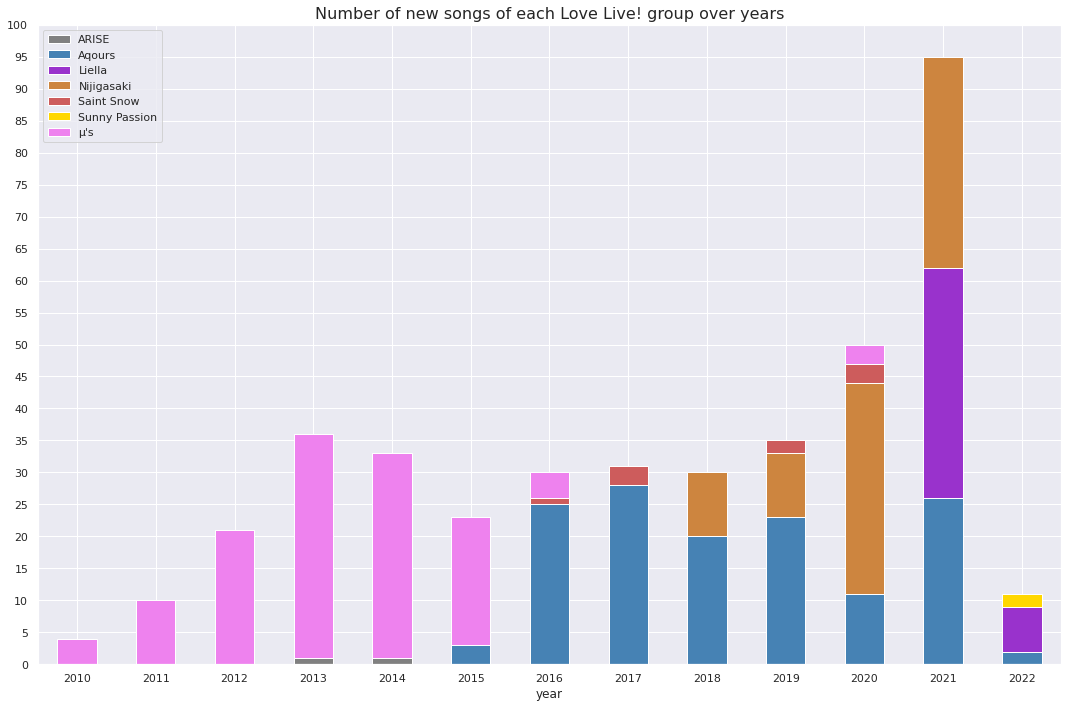

In [40]:
group_year_count.unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(15, 10),
)
plt.title('Number of new songs of each Love Live! group over years', fontsize=16)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

group_color = {
    'Aqours': 'steelblue',
    'Nijigasaki': 'peru',
    'Liella': 'darkorchid',
    'Sunny Passion': 'gold',
    'μ\'s': 'violet',
    'ARISE': 'grey',
    'Saint Snow': 'indianred'
}

yticks = ax.get_yticks()
ax.set_yticks(np.arange(min(yticks), max(yticks) + 5, 5))

for group_bar in ax.containers:
    color = group_color[group_bar.get_label()]
    for bar in group_bar:
        bar.set_facecolor(color)

plt.legend()
plt.tight_layout()

plt.savefig(os.path.join('images', 'new_songs_per_year.png'), dpi=300)

## Number of songs undertaken by each staff (composers and arrangers), categorized by group

In [41]:
all_staffs = song_df.apply(lambda row: list(set(row['composers']).union(row['arrangers'])), axis=1)

In [42]:
song_df['all_staffs'] = all_staffs

In [43]:
staff_count = song_df.explode('all_staffs').explode('main_group').groupby(['all_staffs', 'main_group']).size()

In [44]:
staff_count

all_staffs    main_group
A-bee         μ's            1
APAZZI        Aqours         1
Akira Sunset  Aqours         2
              Nijigasaki     8
Ankle Break   Aqours         1
                            ..
高田 暁          μ's           11
高阪昌至          μ's            1
黒川陽介          Aqours         1
黒須克彦          μ's            2
齊藤庸介          Nijigasaki     1
Length: 279, dtype: int64

In [45]:
staff_count = staff_count.unstack()
staff_count

main_group,ARISE,Aqours,Liella,Nijigasaki,Saint Snow,Sunny Passion,μ's
all_staffs,,,,,,,
A-bee,NaN,NaN,NaN,NaN,NaN,NaN,1.0
APAZZI,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Akira Sunset,NaN,2.0,NaN,8.0,NaN,NaN,NaN
Ankle Break,NaN,1.0,NaN,NaN,NaN,NaN,NaN
ArmySlick,NaN,NaN,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
高田 暁,NaN,9.0,NaN,NaN,NaN,NaN,11.0
高阪昌至,NaN,NaN,NaN,NaN,NaN,NaN,1.0
黒川陽介,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [46]:
staff_count['total'] = staff_count.sum(axis=1)
staff_count

main_group,ARISE,Aqours,Liella,Nijigasaki,Saint Snow,Sunny Passion,μ's,total
all_staffs,,,,,,,,
A-bee,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
APAZZI,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0
Akira Sunset,NaN,2.0,NaN,8.0,NaN,NaN,NaN,10.0
Ankle Break,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0
ArmySlick,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...
高田 暁,NaN,9.0,NaN,NaN,NaN,NaN,11.0,20.0
高阪昌至,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
黒川陽介,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0


In [47]:
staff_count = staff_count.sort_values('total').tail(30)
staff_count

main_group,ARISE,Aqours,Liella,Nijigasaki,Saint Snow,Sunny Passion,μ's,total
all_staffs,,,,,,,,
矢鴇つかさ,NaN,1.0,NaN,1.0,NaN,NaN,3.0,5.0
山田高弘,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0
藤澤慶昌,NaN,NaN,4.0,NaN,NaN,NaN,2.0,6.0
原田 篤,NaN,3.0,NaN,NaN,NaN,NaN,3.0,6.0
PASSiON KiNG,NaN,NaN,NaN,6.0,NaN,NaN,NaN,6.0
小高光太郎,NaN,5.0,NaN,1.0,NaN,NaN,NaN,6.0
遠藤ナオキ,NaN,NaN,NaN,6.0,NaN,NaN,NaN,6.0
Keisuke Koyama,NaN,2.0,NaN,5.0,NaN,NaN,NaN,7.0
酒井拓也,NaN,5.0,NaN,NaN,NaN,NaN,2.0,7.0


In [48]:
del staff_count['total']

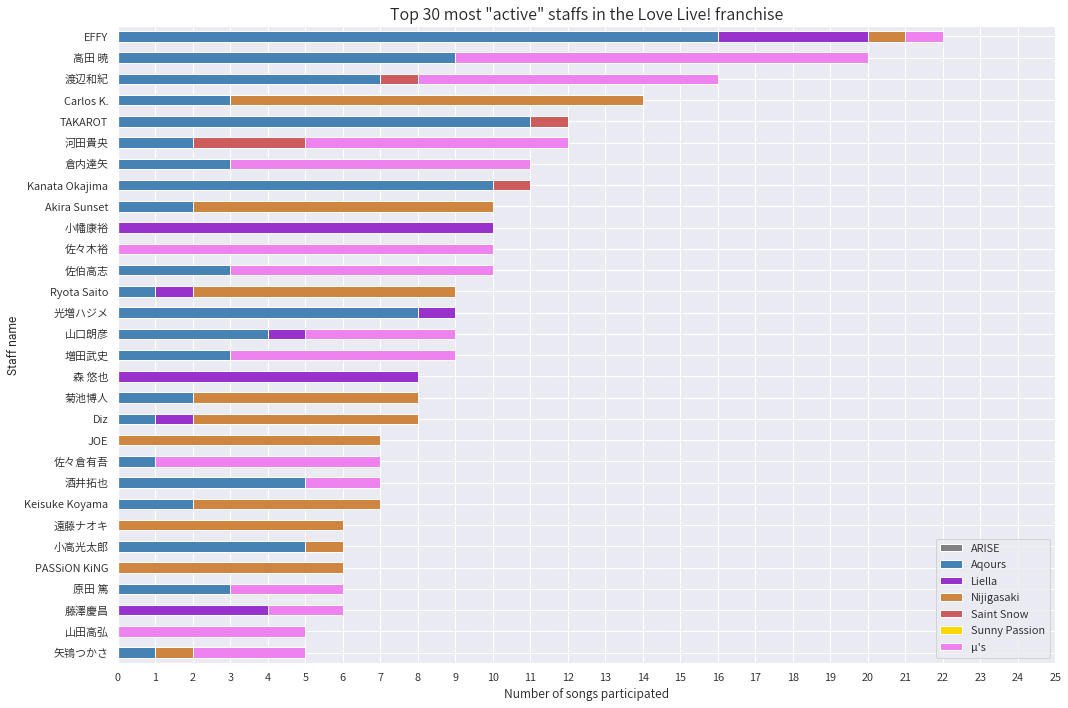

In [49]:
staff_count.plot(
    kind='barh',
    stacked=True,
    figsize=(15, 10)
)

plt.rcParams['font.sans-serif'] = ['Source Han Sans JP']

plt.title('Top 30 most "active" staffs in the Love Live! franchise', fontsize=16)
ax = plt.gca()
ax.set_ylabel('Staff name', font='Roboto')
ax.set_xlabel('Number of songs participated')

xticks = ax.get_xticks()
ax.set_xticks(np.arange(min(xticks), max(xticks) + 1, 1))

for group_bar in ax.containers:
    color = group_color[group_bar.get_label()]
    for bar in group_bar:
        bar.set_facecolor(color)

plt.legend()
plt.tight_layout()

plt.savefig(os.path.join('images', 'staff_songs.png'), dpi=300)

## Number of songs undertaken by each lyricist, categorized by group

In [58]:
lr_count = song_df.explode('lyricists').explode('main_group').groupby(['lyricists', 'main_group']).size()

In [59]:
lr_count

lyricists       main_group   
Akira Sunset    Nijigasaki         8
Ayaka Miyake    Nijigasaki        20
BEATNINE        Nijigasaki         5
Carlos K.       Nijigasaki         2
DAICHI          Nijigasaki         1
Diz             Nijigasaki         1
Dummy Dog       Nijigasaki         4
Herman Hupfeld  μ's                1
JOE             Nijigasaki         3
KEN THE 390     Liella             1
Kanata Okajima  Nijigasaki         2
Lauren Kaori    Sunny Passion      2
NOVECHIKA       Nijigasaki         4
PASSiON KiNG    Nijigasaki         1
Rico            Nijigasaki         2
Ryota Saito     Nijigasaki         8
T4K             Nijigasaki         1
hot tears       Nijigasaki         1
miyakei         Nijigasaki         2
nana hatori     Nijigasaki         4
shun ÷1         Nijigasaki         1
クボナオキ           Nijigasaki         1
中村 歩            Nijigasaki         2
京極尚彦            Liella             2
                μ's                1
宮嶋淳子            Liella            34
月見草     

In [60]:
lr_count = lr_count.unstack()
lr_count

main_group,ARISE,Aqours,Liella,Nijigasaki,Saint Snow,Sunny Passion,μ's
lyricists,,,,,,,
Akira Sunset,NaN,NaN,NaN,8.0,NaN,NaN,NaN
Ayaka Miyake,NaN,NaN,NaN,20.0,NaN,NaN,NaN
BEATNINE,NaN,NaN,NaN,5.0,NaN,NaN,NaN
Carlos K.,NaN,NaN,NaN,2.0,NaN,NaN,NaN
DAICHI,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Diz,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Dummy Dog,NaN,NaN,NaN,4.0,NaN,NaN,NaN
Herman Hupfeld,NaN,NaN,NaN,NaN,NaN,NaN,1.0
JOE,NaN,NaN,NaN,3.0,NaN,NaN,NaN


In [61]:
lr_count['total'] = lr_count.sum(axis=1)
lr_count

main_group,ARISE,Aqours,Liella,Nijigasaki,Saint Snow,Sunny Passion,μ's,total
lyricists,,,,,,,,
Akira Sunset,NaN,NaN,NaN,8.0,NaN,NaN,NaN,8.0
Ayaka Miyake,NaN,NaN,NaN,20.0,NaN,NaN,NaN,20.0
BEATNINE,NaN,NaN,NaN,5.0,NaN,NaN,NaN,5.0
Carlos K.,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2.0
DAICHI,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0
Diz,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0
Dummy Dog,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0
Herman Hupfeld,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
JOE,NaN,NaN,NaN,3.0,NaN,NaN,NaN,3.0


In [62]:
lr_count = lr_count.sort_values('total')
lr_count

main_group,ARISE,Aqours,Liella,Nijigasaki,Saint Snow,Sunny Passion,μ's,total
lyricists,,,,,,,,
要田 健,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0
栗原 暁,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0
柿沼雅美,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0
藤原彩豊,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0
クボナオキ,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0
shun ÷1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0
鈴木まなか,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0
hot tears,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0
T4K,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0


In [63]:
del lr_count['total']

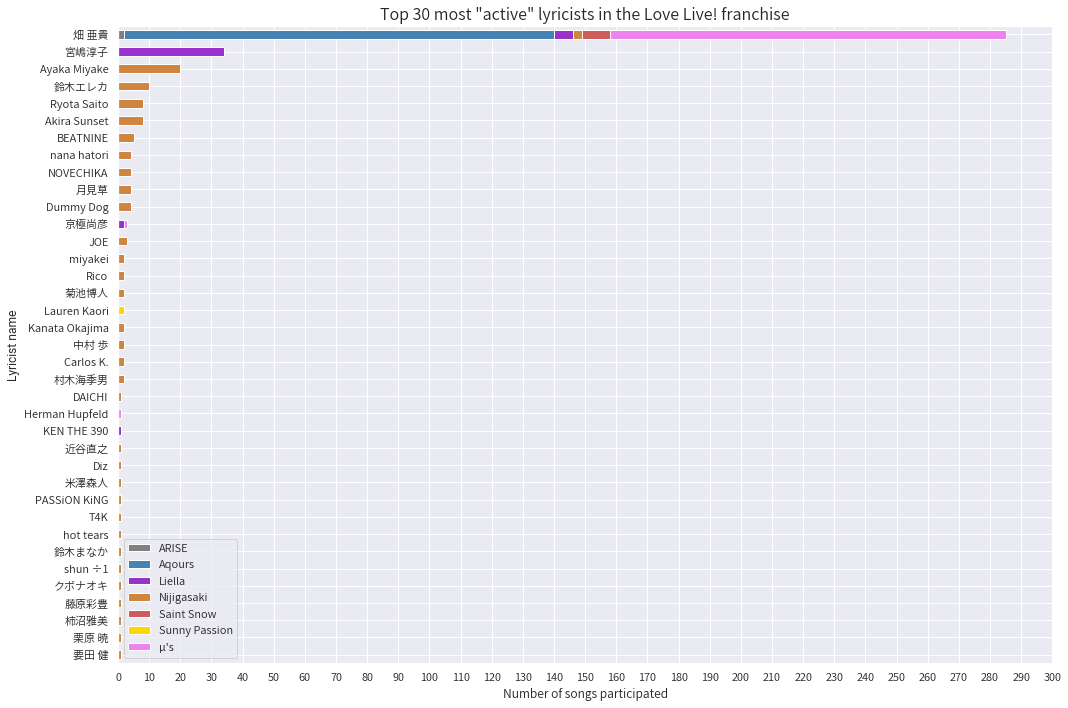

In [64]:
lr_count.plot(
    kind='barh',
    stacked=True,
    figsize=(15, 10)
)
plt.title('Top 30 most "active" lyricists in the Love Live! franchise', fontsize=16)

plt.rcParams['font.sans-serif'] = ['Source Han Sans JP']

ax = plt.gca()
ax.set_ylabel('Lyricist name', font='Roboto')
ax.set_xlabel('Number of songs participated')

xticks = ax.get_xticks()
ax.set_xticks(np.arange(min(xticks), max(xticks) + 10, 10))

for group_bar in ax.containers:
    color = group_color[group_bar.get_label()]
    for bar in group_bar:
        bar.set_facecolor(color)

plt.legend()
plt.tight_layout()

plt.savefig(os.path.join('images', 'lyricists_songs.png'), dpi=300)